<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/autoencoders/DUDL_autoenc_codeChallenge_Nunits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

import sys

# Import and process the data

In [2]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

# Convert to tensor
data_tensor   = torch.tensor(data_norm).float()

# Create the DL model

In [3]:
# Create a class for the model
def create_the_MNIST_AE(n_enc, n_bottle):
    """
    AUTOENCODER_HOW_MANY_UNIT
    """
    class ae_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, n_enc)

            # Encoder layer
            self.encoding = nn.Linear(n_enc, n_bottle)

            # Latent layer
            self.bottleneck = nn.Linear(n_bottle, n_enc)

            # Decoder layer
            self.decoding = nn.Linear(n_enc, 784)
    
        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.encoding(x))
            x = F.relu(self.bottleneck(x))
            y = torch.sigmoid(self.decoding(x))

            return y
    
    # Create the model instance
    net = ae_net()

    # Loss function
    loss_func = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

    return net, loss_func, optimizer

# Create a function that trains the model

In [4]:
def train_the_model(n_enc, n_bottle):
    """
    AUTOENCODER_HOW_MANY_UNIT
    """

    num_epochs = 3

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_AE(n_enc, n_bottle)

    # Initialize losses
    losses = []

    # Batch size and number of batches
    batch_size = 32
    num_batch  = int(data_tensor.shape[0] / batch_size)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Get a permuted index vector
        rand_idx = np.random.permutation(data_tensor.shape[0]).astype(int)

        # Lossed during batches
        batch_losses = []

        for batch_i in range(num_batch):

            # Samples to use in this batch
            samps_2_use = range((batch_i - 1) * batch_size, batch_i * batch_size)

            # Select those images
            X = data_tensor[rand_idx[samps_2_use], :]

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, X)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses in this batch
            batch_losses.append(loss.item())
        # End minibatch loop

        losses.append(np.mean(batch_losses[-3:]))
    
    # End epochs
    # Function output
    return losses, net

# Run the experiment!

In [5]:
# Specific the number of units
N_encdec_units = np.linspace(start=10, stop=500, num=12).astype(int)
N_bottle_units = np.linspace(start=5,  stop=100, num=8) .astype(int)

# Initialize results matrix
exp_results = np.zeros((len(N_encdec_units), len(N_bottle_units)))

# Start the experiment
for N_encdec_idx, N_encdec_i in enumerate(N_encdec_units):
    for N_bottle_idx, N_bottle_i in enumerate(N_bottle_units):

        # Build/Train the model
        losses = train_the_model(N_encdec_i, N_bottle_i)[0] # Only need the first output
        exp_results[N_encdec_idx, N_bottle_idx] = np.mean(losses[-1])

        # Send update message
        current_iter = N_encdec_idx * len(N_bottle_units) + N_bottle_idx + 1
        total_iter   = len(N_bottle_units) * len(N_encdec_units)
        msg          = 'Finished experiment {:<2}/{:<2}'.format(current_iter, total_iter)
        sys.stdout.write('\r' + msg)

Finished experiment 96/96

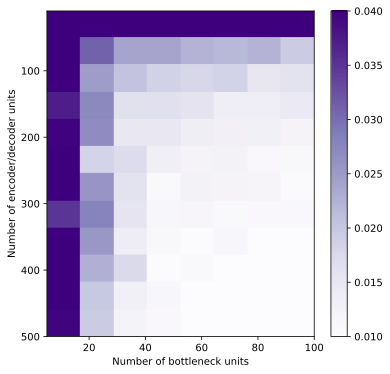

In [6]:
# Show the result matrix
fig = plt.figure(figsize=(6, 6))

plt.imshow(exp_results, aspect='auto',              # Data and aspect ratio
           vmin=0.01, vmax=0.04, cmap='Purples',    # Color range and palette
           extent=[N_bottle_units[0], N_bottle_units[-1], N_encdec_units[-1], N_encdec_units[0]]) # xy axis ticks

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()

plt.show()

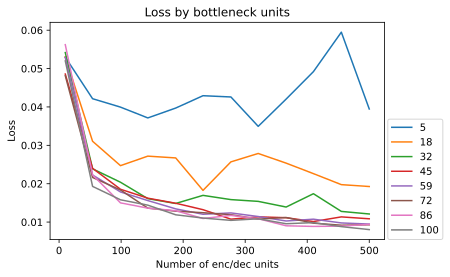

In [7]:
plt.plot(N_encdec_units, exp_results)
plt.legend(N_bottle_units, loc=(1.01, 0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()

# Additional explorations

In [8]:
# 1) Because the full experiment takes a long time, it's not pratical to add another factor. Fix the number of encoder
#    units to 100 and instead parametrically explore the learning rate. You don't need so many learning rates, just use
#    [.0001, .001, .01]. The results can be shown in a line plot, with one line per lr and bottleneck units on the x-axis.
# 
# 2) Smooth transitions across parameters are easy to interpret. But the image plot shows a sharp transition for small
#    numbers of bottleneck units. This rings alarm bells for any experimental scientist! It means that something is 
#    happening at that region of parameter space and you should investigate. Thus, re-run the experiment but change the
#    parameters to focus specifically on the region of the parameter space where there are large changes in the results.
# 